In [280]:
import matplotlib.pyplot as plt
import cv2
import numpy as np
from math import inf
import random
from IPython.display import clear_output

In [281]:
def MSE(block1, block2):
    return np.mean(np.square(np.subtract(block1, block2),dtype=np.int32))

def search(bloc1,searchBox,searchImg,bloc_width,bloc_height,coordinates):
    mse = +inf
    limitX = (searchBox[1][0] - bloc_width) + 1
    limitY = (searchBox[1][1] - bloc_height)+ 1
    box2_coordinates = coordinates

    for y in range(searchBox[0][1],limitY):
        for x in range(searchBox[0][0],limitX):
                bloc2 = searchImg[y:y+bloc_height,x:x+bloc_width]
                temp = MSE(bloc1,bloc2)
                if temp < mse:
                    mse = temp
                    box2_coordinates=[(x,y),(x+bloc_width,y+bloc_height)]
    return box2_coordinates

def logarithmicSearch(bloc1,searchBox,searchImg,bloc_width,bloc_height,width,height,span,coordinates):
    mse = +inf
    limitX = (searchBox[1][0] - bloc_width) + 1
    limitY = (searchBox[1][1] - bloc_height)+ 1
    box2_coordinates = coordinates

    for y in range(searchBox[0][1],limitY,span):
        for x in range(searchBox[0][0],limitX,span):
                bloc2 = searchImg[y:y+bloc_height,x:x+bloc_width]
                temp = MSE(bloc1,bloc2)
                if temp < mse:
                    mse = temp
                    box2_coordinates=[(x,y),(x+bloc_width,y+bloc_height)]
    searchBox = get_searchBox(box2_coordinates,width,height,span//2)
    if searchBox[1][0] - searchBox[0][0] <= bloc_width or searchBox[1][1] - searchBox[0][1] <= bloc_height:
    #if span == 1:
        return box2_coordinates
    else:
        return_value = logarithmicSearch(bloc1,searchBox,searchImg,bloc_width,bloc_height,width,height,span//2,coordinates)
        return return_value

def betterSearch(bloc1,searchBox,searchImg,bloc_width,bloc_height,width,height,span,coordinates):
    mse = +inf

    factor = 2
    
    limitX = (searchBox[1][0] - bloc_width) + 1
    limitY = (searchBox[1][1] - bloc_height)+ 1
    box2_coordinates = coordinates

    for y in range(searchBox[0][1],limitY,bloc_height//factor):
        for x in range(searchBox[0][0],limitX,bloc_width//factor):
                bloc2 = searchImg[y:y+bloc_height,x:x+bloc_width]
                temp = MSE(bloc1,bloc2)
                if temp < mse:
                    mse = temp
                    box2_coordinates=[(x,y),(x+bloc_width,y+bloc_height)]
    searchBox = get_searchBox(box2_coordinates,width,height,span//2)
    if searchBox[1][0] - searchBox[0][0] <= bloc_width or searchBox[1][1] - searchBox[0][1] <= bloc_height:
    #if span == 1:
        return box2_coordinates
    else:
        return_value = betterSearch(bloc1,searchBox,searchImg,bloc_width,bloc_height,width,height,span//2,coordinates)
        return return_value



def get_searchBox(coordinates,width,height,span):
    
    #si on a assez d'espace on soustrat sinon c'est egale a 0 ou le max

    if coordinates[0][0] < span : topLeftX = 0
    else : topLeftX = coordinates[0][0] - span

    if coordinates[0][1] < span : topLeftY = 0
    else : topLeftY = coordinates[0][1] - span

    if coordinates[1][0] > width - span : bottomRightX = width
    else : bottomRightX = coordinates[1][0] + span

    if coordinates[1][1] > height - span : bottomRightY = height
    else : bottomRightY = coordinates[1][1] + span

    return [(topLeftX,topLeftY),(bottomRightX,bottomRightY)]
    
def rand_color():
    r = random.randint(50,200) 
    g = random.randint(50,200) 
    b = random.randint(50,200) 
    return (r,g,b)
def draw_greenBox(img,coordinates):
    if coordinates is not None:
        cv2.rectangle(img, 
        (coordinates[0][0], coordinates[0][1]), 
        (coordinates[1][0], coordinates[1][1]), 
        (0 , 255, 0), 2)

def draw_redBox(img,coordinates):
    if coordinates is not None:
        cv2.rectangle(img, 
        (coordinates[0][0], coordinates[0][1]), 
        (coordinates[1][0], coordinates[1][1]), 
        (0, 0, 255), 2)

print(rand_color())

(118, 74, 51)


In [282]:
bloc_width,bloc_height = 16,16
seuil = 50



span = 64

image1 = "image092.png"
image2 = "image072.png"


img1 = cv2.imread(image1)
img2 = cv2.imread(image2)

img1 = cv2.copyMakeBorder(img1, span, span, span, span, cv2.BORDER_CONSTANT, value=[0,0,0])
img2 = cv2.copyMakeBorder(img2, span, span, span, span, cv2.BORDER_CONSTANT, value=[0,0,0])

blocimg_source = img1.copy()
blocimg_found = img2.copy()

vertor_arrows = img1.copy()
imgpredict = img1.copy()

Timg1 = np.array(cv2.cvtColor(img1, cv2.COLOR_BGR2YCrCb))
Yimg1 = np.array(Timg1[:,:,0],np.int16)

Timg2 = np.array(cv2.cvtColor(img2, cv2.COLOR_BGR2YCrCb))
Yimg2 = np.array(Timg2[:,:,0],np.int16)

#print(MSE(Yimg1,Yimg2))

width = Timg1.shape[1]
height = Timg1.shape[0]


In [283]:
#pour ne pas depasser la limite
limitX = width - (width % bloc_width)
limitY = height- (height % bloc_height)



imgresidus1 = np.zeros((img1.shape[0],img1.shape[1],3),np.uint8)
imgresidus1 = np.array(cv2.cvtColor(imgresidus1, cv2.COLOR_RGB2YCrCb),np.int16)


for y in range (0,limitY,bloc_height):
    clear_output()
    print((y/limitY)*100,"%")
    for x in range(0,limitX,bloc_width):
        
        #bloc caracterisé par deux points
        topLeftX = x
        topLeftY = y
        bottomRightX = x+bloc_width
        bottomRightY = y+bloc_height

        #prendre une bloc de le l'image 
        Ybloc1 = Yimg1[topLeftY:bottomRightY,topLeftX:bottomRightX]
        Ybloc2 = Yimg2[topLeftY:bottomRightY,topLeftX:bottomRightX]
        if seuil < MSE(Ybloc1,Ybloc2):
            coordinates = [(topLeftX,topLeftY),(bottomRightX,bottomRightY)]
            draw_redBox(blocimg_source,coordinates)
            searchBox = get_searchBox(coordinates,width,height,span)

            greenBox = search(Ybloc1,searchBox,Yimg2,bloc_width,bloc_height,coordinates)
            #greenBox = logarithmicSearch(Ybloc1,searchBox,Yimg2,bloc_width,bloc_height,width,height,32,coordinates)
            #greenBox = betterSearch(Ybloc1,searchBox,Yimg2,bloc_width,bloc_height,width,height,span,coordinates)
            
            draw_greenBox(blocimg_found,greenBox)

            imgresidus1[topLeftY:bottomRightY,topLeftX:bottomRightX,0] = Yimg2[greenBox[0][1]:greenBox[1][1],greenBox[0][0]:greenBox[1][0]] - Yimg1[topLeftY:bottomRightY,topLeftX:bottomRightX]
            imgpredict[topLeftY:bottomRightY,topLeftX:bottomRightX] = img2[greenBox[0][1]:greenBox[1][1],greenBox[0][0]:greenBox[1][0]]
            cv2.arrowedLine(vertor_arrows , coordinates[0],greenBox[0],rand_color(),2)



98.66666666666667 %


(-0.5, 2047.5, 1207.5, -0.5)

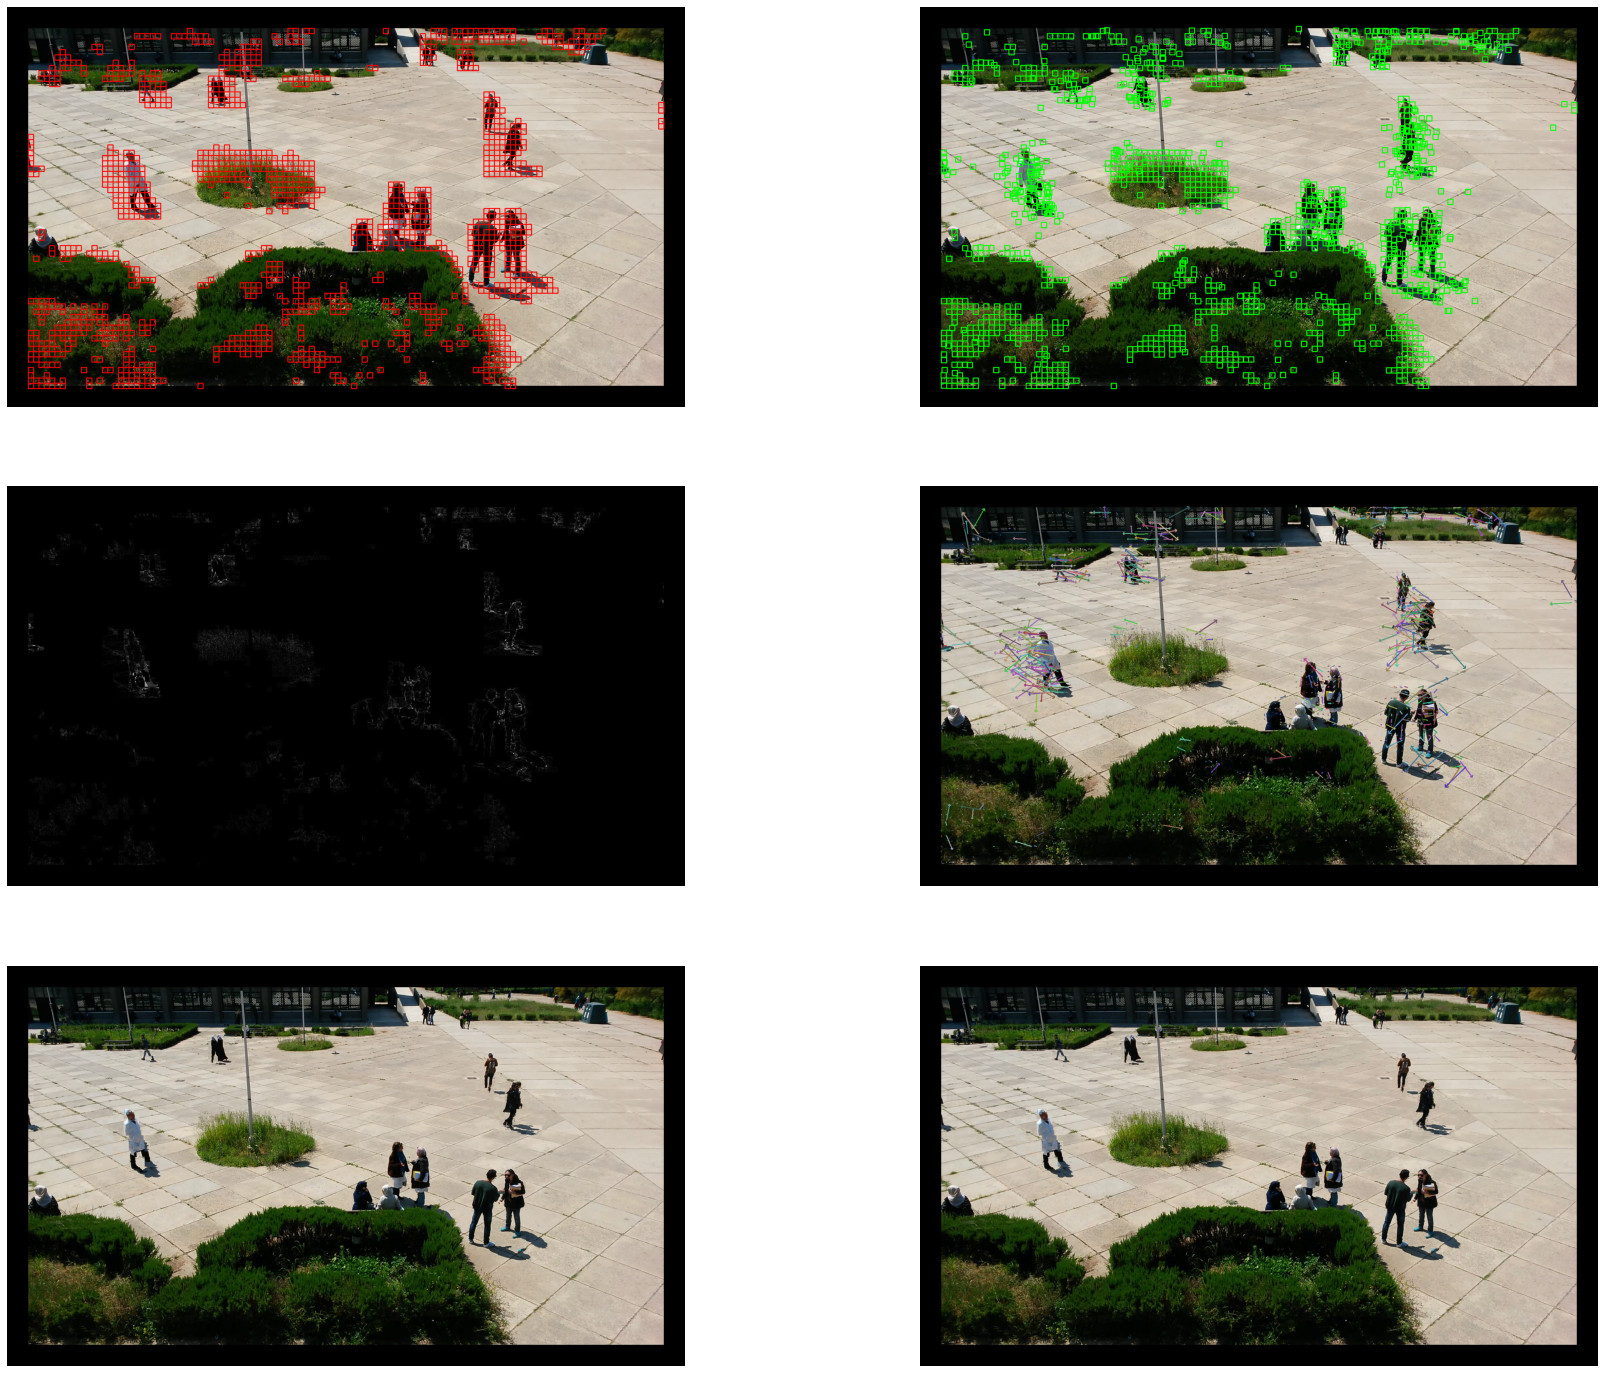

In [284]:
rows = 3
columns = 2

imgresidus1 = np.abs(imgresidus1)
imgresidus1 = np.array(imgresidus1,np.uint8)

Timgpredict = np.array(cv2.cvtColor(imgpredict, cv2.COLOR_BGR2YCrCb),np.uint8)
Timgpredict[:,:,0] = np.maximum(cv2.cvtColor(imgresidus1, cv2.COLOR_YCrCb2BGR)[:,:,0],Timgpredict[:,:,0])
final_img = cv2.cvtColor(Timgpredict, cv2.COLOR_YCrCb2BGR)

cv2.imwrite("boxes_source.png",blocimg_source)
cv2.imwrite("boxes_found.png",blocimg_found)

cv2.imwrite("residus.png",cv2.cvtColor(imgresidus1, cv2.COLOR_YCrCb2BGR))
cv2.imwrite("vertor_arrows.png",vertor_arrows)

cv2.imwrite("predictive.png",imgpredict)

fig = plt.figure(figsize = (30,25))
fig.tight_layout()

fig.add_subplot(rows, columns, 1)
plt.imshow(cv2.cvtColor(blocimg_source, cv2.COLOR_BGR2RGB))
plt.axis('off')

fig.add_subplot(rows, columns, 2)
plt.imshow(cv2.cvtColor(blocimg_found, cv2.COLOR_BGR2RGB))
plt.axis('off')

fig.add_subplot(rows, columns, 3)
plt.imshow(cv2.cvtColor(imgresidus1, cv2.COLOR_YCrCb2RGB))
plt.axis('off')

fig.add_subplot(rows, columns, 4)
plt.imshow(cv2.cvtColor(vertor_arrows, cv2.COLOR_BGR2RGB))
plt.axis('off')

fig.add_subplot(rows, columns, 5)
plt.imshow(cv2.cvtColor(imgpredict, cv2.COLOR_BGR2RGB))
plt.axis('off')


